In [1]:
from astropy.io import ascii

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import numpy as np
import astropy.units as u

from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline



In [2]:
pgf_with_rc_fonts = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "font.size": 12,
    "legend.fontsize": 12,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_rc_fonts)
# full page plot:
figwidth  = 35/ 2.54 

# half page plot:
#figwidth  = 16 / 2.54 

# half page plot:
#figwidth  = 11.6 / 2.54 

# ratio:
ratio = 0.65

image_resolution = 5000

figheight  = ratio * figwidth

from palettable.scientific.sequential import Oslo_9 as colormap

#from palettable.colorbrewer.qualitative import Dark2_7 as colormap
#from palettable.cartocolors.qualitative import Bold_4 as colormap
#from palettable.colorbrewer.qualitative import Set1_4 as colormap


cmap = colormap.get_mpl_colormap()
cmap = mpl.cm.get_cmap("bone").copy()
cmap.set_under("w") # sets background to white

        

In [3]:
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interp1d(logx, logy, kind=kind, bounds_error=False)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp


In [4]:
def data_on_grid(x, y, grid, interpolation_kind='linear', unit='TeV', loglog=True):
    y_unit = y.unit
    if loglog==True:
        interpol_model=log_interp1d(x.to('TeV').value, y.value, kind=interpolation_kind)
        ys_loginterp=interpol_model(x_grid.to('TeV').value)
        
    return ys_loginterp * y_unit

In [5]:
def make_grid(xmin, xmax, npoints=300, unit='TeV', log=True):
    xmin_val = xmin.to('TeV').value
    xmax_val = xmax.to('TeV').value
    if log==True:
        x_grid = np.logspace(np.log10(xmin_val), np.log10(xmax_val), npoints)
    else:
        x_grid = np.linspace(xmin_val, xmax_val, npoints)
    return (x_grid *u.TeV).to(unit)

In [6]:
xmin = 1*u.GeV
xmax = 100*u.TeV

In [7]:
x_grid = make_grid(xmin, xmax, npoints=1000, unit='TeV', log=True)

In [8]:
data_fermi2020 = ascii.read("bounds/fermi/fermi_2020_multidsph_ann_bb_oneD_frequentist.ecsv")
data_fermi2017 = ascii.read("bounds/fermi/fermi_2017_multidsph_ann_bb.ecsv") 
data_magic = ascii.read("bounds/magic/magic_2022_combined4_ann_bb.ecsv") 
data_hawc = ascii.read("bounds/hawc/hawc_2017_multidsph_ann_bb_notri2.ecsv") 
data_hess_fornax = ascii.read("bounds/hess/hess_2012_fornaxcluster_ann_bb_nfwrb02.ecsv") 


legend_channel = ascii.read("legend_experiments.ecsv") 

In [9]:
fermi_2020_gridded = data_on_grid(data_fermi2020['mass'], data_fermi2020['sigmav'], x_grid, interpolation_kind='quadratic')
fermi_2017_gridded = data_on_grid(data_fermi2017['mass'], data_fermi2017['sigmav'], x_grid, interpolation_kind='quadratic')
magic_gridded = data_on_grid(data_magic['mass'], data_magic['sigmav'], x_grid, interpolation_kind='quadratic')
hawc_gridded = data_on_grid(data_hawc['mass'], data_hawc['sigmav'], x_grid, interpolation_kind='quadratic')

In [10]:
envelope= []

for i in range(len(x_grid)):
    val1 = fermi_2020_gridded[i].value
    if np.isnan(val1): val1 =1e40
    val2 = fermi_2017_gridded[i].value
    if np.isnan(val2): val2 =1e40
    val3 = magic_gridded[i].value
    if np.isnan(val3): val3 =1e40
    minvals = [val1, val2, val3]
    envelope.append(0.95*min(minvals))

In [11]:
data_fermi2020['mass'] = data_fermi2020['mass'].to('TeV')
data_fermi2017['mass'] = data_fermi2017['mass'].to('TeV')
data_magic['mass'] = data_magic['mass'].to('TeV')
data_hawc['mass'] = data_hawc['mass'].to('TeV')
data_hess_fornax['mass'] = data_hess_fornax['mass'].to('TeV')

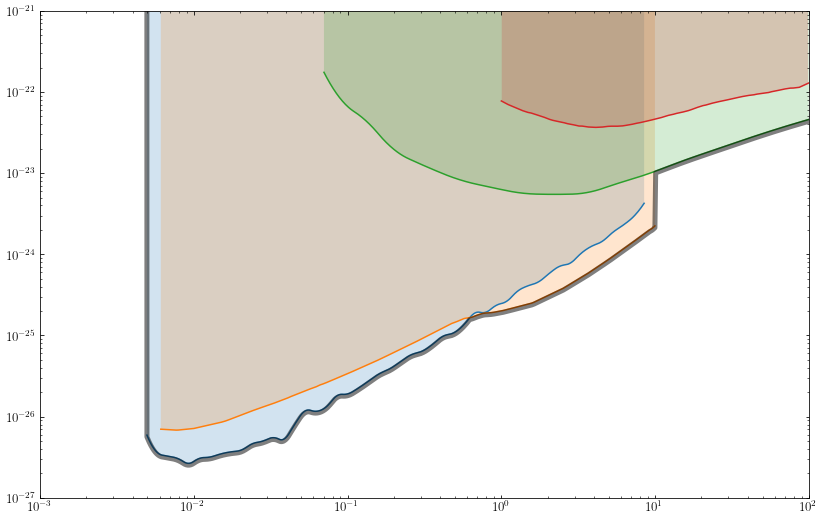

In [12]:

plot_limits = plt.figure(figsize=(figwidth, figheight))
plt.plot(x_grid, fermi_2020_gridded)
plt.plot(x_grid, fermi_2017_gridded)
plt.plot(x_grid, magic_gridded)

#plt.plot(data_magic['mass'], data_magic['sigmav'])
plt.plot(data_hawc['mass'], data_hawc['sigmav'])
#plt.plot(data_hess_fornax['mass'], data_hess_fornax['sigmav'])
plt.fill_between(x_grid.value, fermi_2020_gridded.value, np.ones(len(x_grid)), alpha=0.2)
plt.fill_between(x_grid.value, fermi_2017_gridded.value, np.ones(len(x_grid)), alpha=0.2)
plt.fill_between(x_grid.value, magic_gridded.value, np.ones(len(x_grid)), alpha=0.2)
plt.fill_between(x_grid.value, hawc_gridded.value, np.ones(len(x_grid)), alpha=0.2)
#plt.fill_between(x_grid.value, fermi_2020_gridded.value, np.ones(len(data_hess_fornax['sigmav'])), alpha=0.2)

plt.plot(x_grid, envelope, linewidth=5, color='k', alpha=0.5)


plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-27,1e-21])
plt.xlim([xmin.to('TeV').value, xmax.to('TeV').value]);

In [13]:
legend_channel

shortname,longname
str8,str9
magic,MAGIC
hess,H.E.S.S.
veritas,VERITAS
whipple,WHIPPLE
cangaroo,CANGAROO
lat,FERMI-LAT
agile,AGILE
lhaaso,LHAASO
hawc,HAWC
